In [1]:
from src.containers.evaluation_container import EvaluationContainer
from src.services.config.config_interface import DirConfig
from src.utils import tqdm_joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import japanize_matplotlib

plt.style.use("ggplot")
dir_config = DirConfig(env='local', exp='eval_proposed', debug=False)

In [3]:
coupon_type_to_color = {
    'control': '#E24A33',
    '5% back': '#348ABD',
    '5% off':'#988ED5',
    '300yen off':'#777777',  
    '10% off': '#FBC15E', 
    '10% back': '#8EBA42', 
    '15% off': '#FFB5B8'
}

In [99]:
def evaluate(exp):
    container = EvaluationContainer(exp, debug=False)
    name = container.config.base_config.name
    container.initialize()
    base_config = container.config.base_config
    config = container.config
    postprocess_config = config.postprocess_config

    n_sample = min(container.test_df.shape[0], postprocess_config.n_sample)
    random_checked = set()
    results =[]
    # self.assignments.append([name, seed, budget_constraint, assignment])
    for seed, budget_constraint, assginment in container.assignments:
        # test_dfからランダムにn_sample個のidxを取得
        sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
        # sample_idxのデータを取得しsample_dfに格納
        sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
        # target列にGMVを代入
        sample_df['target'] = sample_df[base_config.target_name]
        # sample_dfのなかで各config.treatment_nameの数をカウント
        n_treatment = sample_df[base_config.treatment_name].value_counts().to_dict()
        n_treatment_all = sum(n_treatment.values())
        # cost列にvariant_no_to_costの値を代入
        sample_df['cost'] = sample_df[base_config.treatment_name].map(postprocess_config.variant_no_to_cost)
            
        # model
        gmv = 0
        cost = 0
        for t in range(1, 7):
            gmv += sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
            gmv -= sample_df['target'][(assginment==t) & (sample_df[base_config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            cost += sample_df['cost'][(assginment==t) & (sample_df[base_config.treatment_name]==t)].sum()
            # cost -= sample_df['cost'][(assginment==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
        rate = (sample_df['target'][(assginment==sample_df[base_config.treatment_name])]!=0).mean()
        results.append([exp, name, seed, cost, gmv, rate, budget_constraint])
    return results

def random_evaluate(exp):
    container = EvaluationContainer(exp, debug=False)
    name = container.config.base_config.name
    container.initialize()
    base_config = container.config.base_config
    config = container.config
    postprocess_config = config.postprocess_config

    n_sample = min(container.test_df.shape[0], postprocess_config.n_sample)
    random_checked = set()
    results =[]
    # self.assignments.append([name, seed, budget_constraint, assignment])
    for seed, budget_constraint, assginment in container.assignments:
        # test_dfからランダムにn_sample個のidxを取得
        sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
        # sample_idxのデータを取得しsample_dfに格納
        sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
        # target列にGMVを代入
        sample_df['target'] = sample_df[base_config.target_name]
        # sample_dfのなかで各config.treatment_nameの数をカウント
        n_treatment = sample_df[base_config.treatment_name].value_counts().to_dict()
        n_treatment_all = sum(n_treatment.values())
        # cost列にvariant_no_to_costの値を代入
        sample_df['cost'] = sample_df[base_config.treatment_name].map(postprocess_config.variant_no_to_cost)
        # # random
        if (seed,budget_constraint) not in random_checked:
            # cost列の累積和がbudget_constraintを超えるidxを取得 frac=1は100%とってきてシャッフル
            # assign_indexはあとで0にするindex
            assgin_index = (sample_df.sample(frac=1)['cost'].cumsum() > budget_constraint).sort_index()
            # assginment列に0~6の乱数を代入 -> 1~6では？ 
            sample_df['assginment'] = np.random.randint(0, 7, len(sample_df))
            # assgin_indexのidxに0を上書き
            sample_df.loc[assgin_index, 'assginment'] = 0
            # upliftgmv
            random_gmv = 0
            cost = 0
            for t in range(1, 7):
                random_gmv += sample_df['target'][(sample_df['assginment']==t) & (sample_df[base_config.treatment_name]==t)].sum()*(n_treatment_all/n_treatment[t])
                random_gmv -= sample_df['target'][(sample_df['assginment']==t) & (sample_df[base_config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
                cost += sample_df['cost'][(sample_df['assginment']==t)& (sample_df[base_config.treatment_name]==t)].sum()
                #cost -= sample_df['cost'][(sample_df['assginment']==t) & (sample_df[config.treatment_name]!=t)].sum()*(n_treatment_all/(1-n_treatment[t]))
            # 一致しているものの割合 -> つかってない
            # 実際のconfig.treatment_nameとassginmentが一致していないものを集計
            random_rate = (sample_df['target'][(assginment==sample_df[base_config.treatment_name])]!=0).mean()
            results.append(['random', seed, cost, random_gmv, random_rate])   
            random_checked.add((seed,budget_constraint))

    return results

def get_random_result(exp, n_trial):
    num_cores = multiprocessing.cpu_count()
    with tqdm_joblib(n_trial):
        results = Parallel(n_jobs=num_cores)([delayed(random_evaluate)(exp) for _ in range(n_trial)])

    # flatten
    results = [result for result_list in results for result in result_list]

    result_df = pd.DataFrame(results, columns=['name', 'seed', 'cost', 'GMV', 'assign_rate'])
    result_df['cost'] = result_df['cost'].astype(int)
    result_df = result_df.groupby('cost')['GMV'].mean().reset_index()
    result_df['name'] = 'random'

    return result_df

def split_name(name):
    return (
        name.str.split(',', expand=True)
        .iloc[:, 2:]
        .applymap(lambda x: x.split('=')[-1] if isinstance(x, str) else None)
        .astype(float)
    )

## 一番良かったExp

In [151]:
## 一番良かったExp
def plot_allocation(container):
    clusters = container.clusters
    assignments = container.assignments
    n_budget = len(assignments)

    # sort by budget
    cluster = sorted(clusters, key=lambda x: x[1])[0][-1]
    assignments = sorted(assignments, key=lambda x: x[1])

    # plot
    fig, axes = plt.subplots(n_budget, 1, figsize=(20, 5 * n_budget))
    for i, (assignment) in enumerate(assignments):
        budget_constraint = assignment[1]
        assignment = assignment[-1]

        df = pd.DataFrame({'cluster': cluster, 'assignment': assignment})
        df = df.sort_values('assignment', ascending=False)
        df = df.groupby(['cluster', 'assignment']).size().reset_index().sort_values('assignment')
        df = df.pivot(index='cluster', columns='assignment', values=0).fillna(0)
        df.columns = list(map(lambda x: container.config.base_config.counpon_config.variant_no_to_coupon_type[x], df.columns))
        (
            df.plot.bar(
                stacked=True, 
                ax=axes[i], 
                legend=True, 
                title=f'budget constraint={budget_constraint:.0f}',
                color=coupon_type_to_color
            )
        )
        axes[i].set_ylabel('クーポン配布数', fontsize=25)
        axes[i].set_xlabel('クラスター番号', fontsize=25)
    
    # fig.tight_layout()

    return fig, axes

def plot_cluster(container):
    cluster = container.clusters[0][-1]
    uplift = container.uplift_pred
    columns = list(container.config.base_config.counpon_config.variant_no_to_coupon_type.values())[1:]
    uplift.columns = columns

    fig, axes = plt.subplots(2, 1, figsize=(20, 5*2), sharey=False, sharex=False)
    # mean uplift
    uplift.groupby(cluster).sum().plot.bar(stacked=True, 
                                           ax=axes[0], 
                                           color=coupon_type_to_color
                                           )
    # std uplift
    uplift.groupby(cluster).std().plot.bar(stacked=True, ax=axes[1], color=coupon_type_to_color)

    axes[0].set_ylabel('総Uplift', fontsize=25)
    axes[1].set_ylabel('標準偏差', fontsize=25)
    axes[0].set_xlabel('クラスター番号', fontsize=25)
    axes[1].set_xlabel('クラスター番号', fontsize=25)
    # fig.tight_layout()

    return fig, axes

In [ ]:
container = EvaluationContainer('optimize205', debug=False) # 最も良かったパラメータのExp
container.initialize()

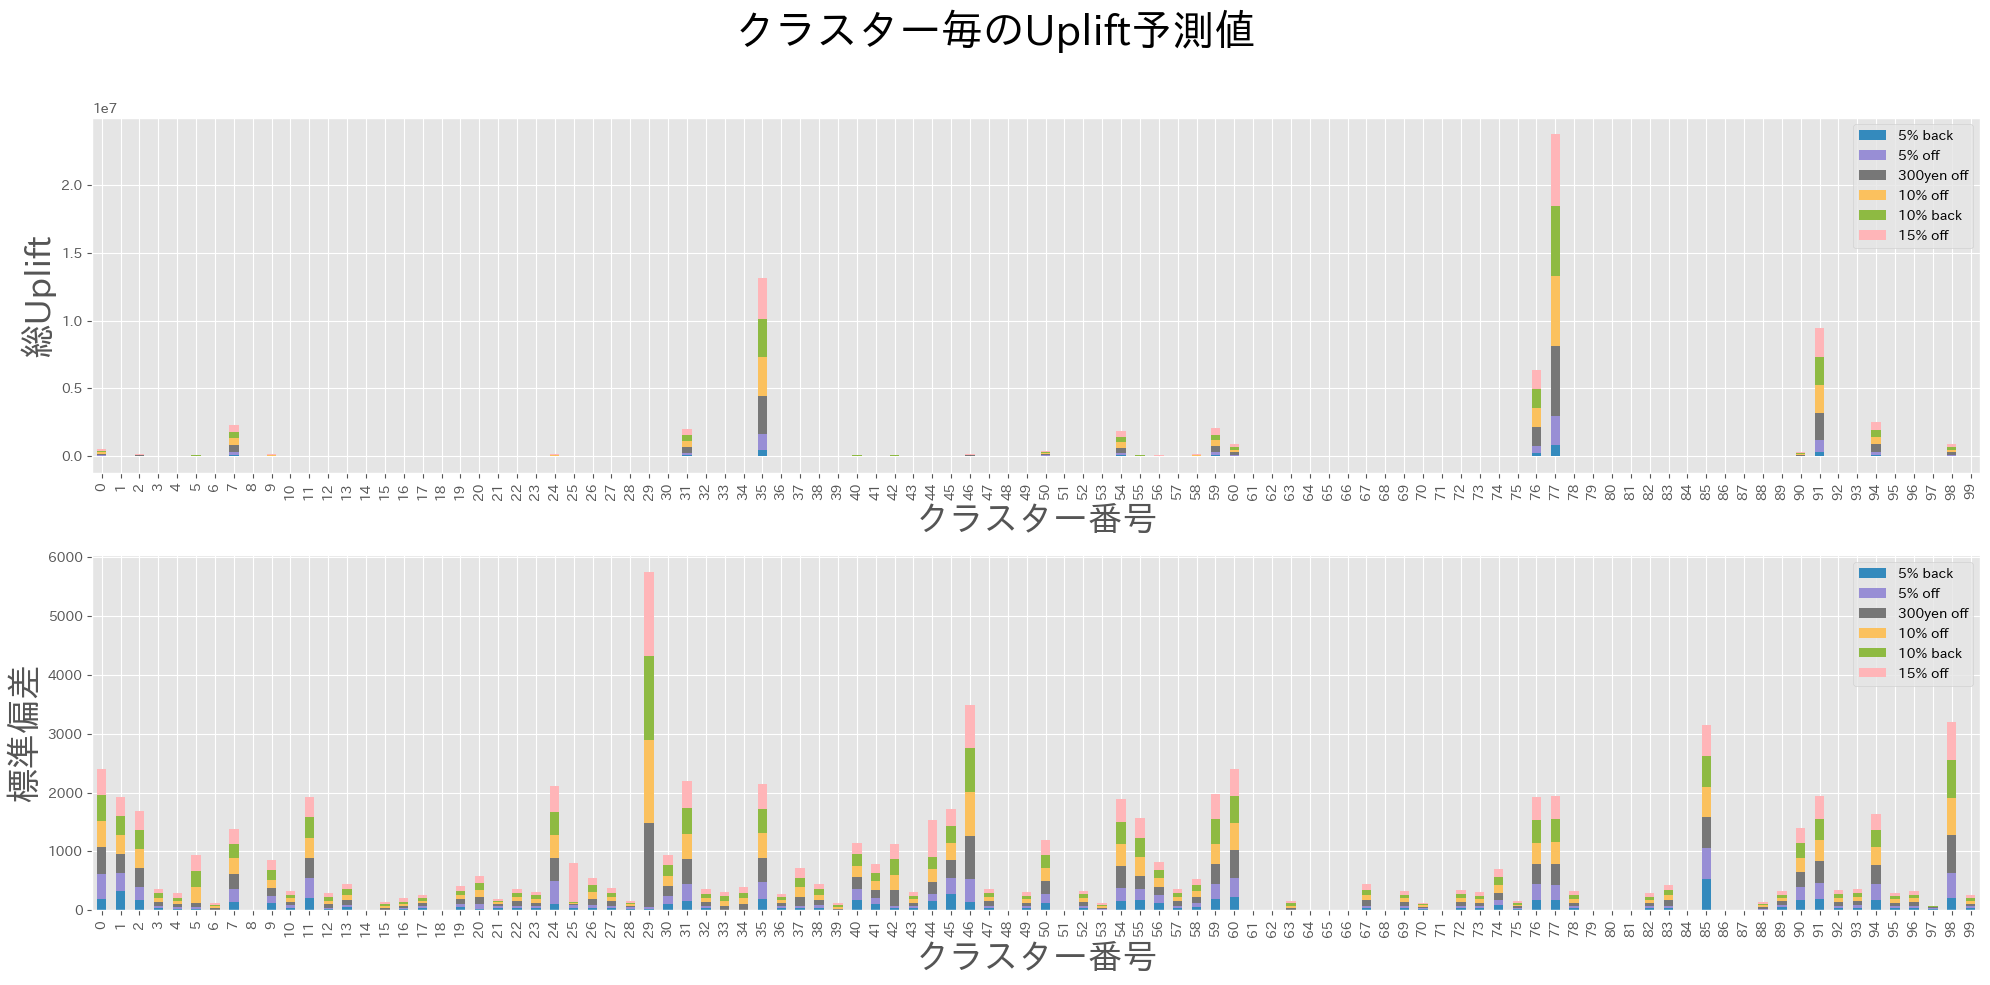

In [134]:
fig, axes = plot_cluster(container)
fig.suptitle('クラスター毎のUplift予測値', fontsize=30)
fig.tight_layout(rect=[0,0,1,0.96])
fig.savefig(dir_config.output_figure_dir / 'cluster.png')

## 最も良かった実験のクーポン配布
- 予算制約が大きくなるにつれコストの大きなクーポンを配布するようになっている

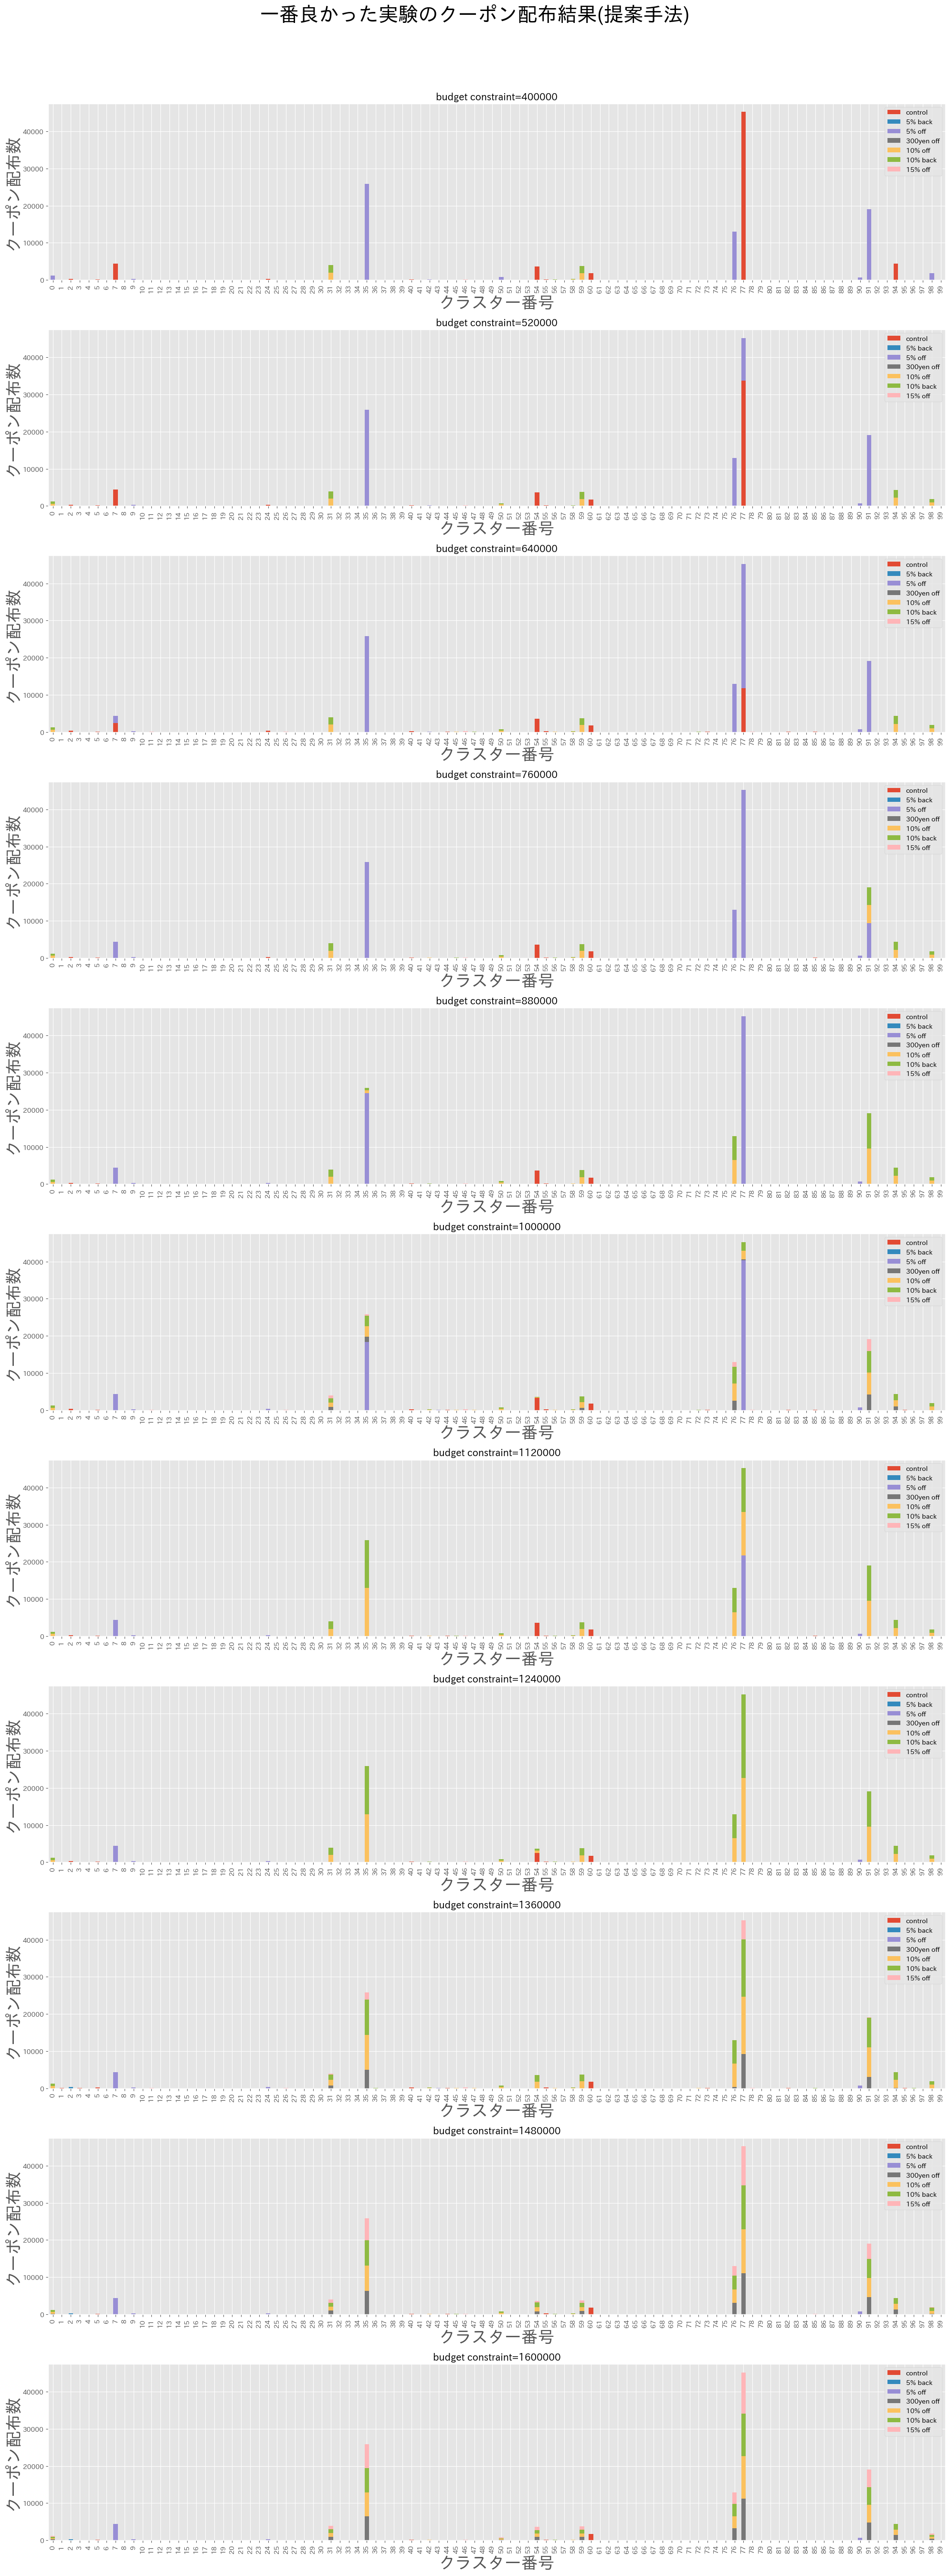

In [152]:
fig, axes = plot_allocation(container)
fig.suptitle('一番良かった実験のクーポン配布結果(提案手法)', fontsize=30)
fig.tight_layout(rect=[0,0,1,0.96])
fig.savefig(dir_config.output_figure_dir / 'allocation.png')

## ハイパーパラメータによる精度変化

In [ ]:
results = []
exps = [f'optimize{i:03}' for i in range(126, 206)]
num_cores = multiprocessing.cpu_count()
with tqdm_joblib(len(exps)):
    results = Parallel(n_jobs=num_cores)([delayed(evaluate)(exp) for exp in exps])

# flatten
results = [item for sublist in results for item in sublist]

result_df = pd.DataFrame(results, columns=['exp', 'name', 'seed', 'cost', 'GMV', 'assign_rate', 'budget_constraint'])
result_df['cost'] = result_df['cost'].astype(int)
result_df = result_df.drop_duplicates().reset_index(drop=True)
result_df['random'] = result_df['name'] == 'random'
result_df = result_df.sort_values(['random', 'name','cost','seed'])
result_df['sum_GMV'] = result_df.groupby('name')['GMV'].transform('sum')
result_df[['alpha', 'cluster', 'gamma']] = split_name(result_df['name'])
result_df['beta'] = result_df['gamma'] / (result_df['cluster'] * 5)

random_result = get_random_result(exps[0], 50)

## alphaによる精度変化

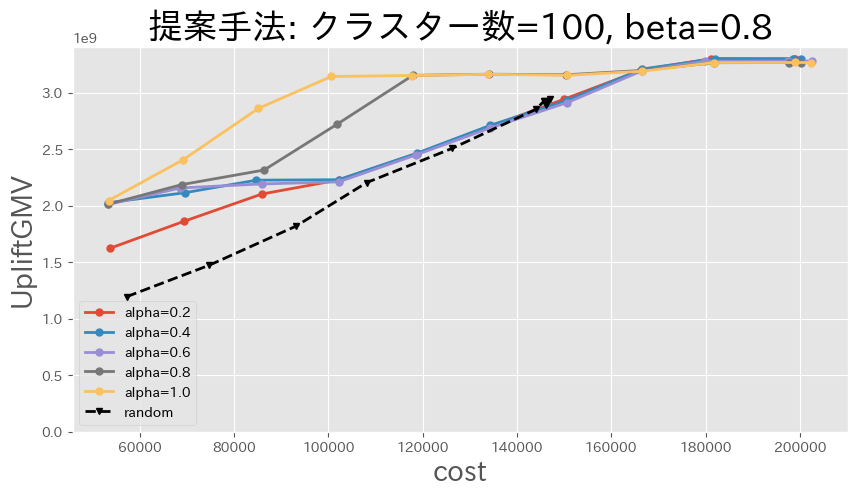

In [153]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in result_df.query('cluster==100 and beta==0.8')['name'].unique():
    _result_df = result_df[result_df['name']==name].reset_index(drop=True)
    cluster = _result_df['cluster'].unique()[0]
    alpha = _result_df['alpha'].unique()[0]
    beta = _result_df['beta'].unique()[0]
    label = f'alpha={alpha}'
    ax.plot(
        _result_df['cost'],
        _result_df['GMV'],
        label=label,
        marker='o',
        markersize=5,
        linewidth=2,
    )
    ax.legend()

ax.plot(
    random_result['cost'],
    random_result['GMV'],
    label='random',
    marker='v',
    markersize=5,
    color='black',
    linestyle='--',
    linewidth=2,
)
ax.legend()
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
ax.set_xlabel('cost', fontsize=20)
ax.set_ylabel('UpliftGMV', fontsize=20)
ax.set_title('提案手法: クラスター数=100, beta=0.8', fontsize=25)
fig.savefig(dir_config.output_figure_dir / 'cluster100_beta08.png')

In [154]:
agg_df = result_df.groupby(['name'])['GMV'].sum().reset_index()
agg_df[['alpha', 'cluster', 'gamma']] = split_name(agg_df['name'])
agg_df['beta'] = agg_df['gamma'] / (agg_df['cluster']*5)
agg_df = agg_df.rename(columns={'GMV': 'Total_GMV', 'cluster': 'クラスター数'})

## ハイパーパラメータによる精度変化

- alpha, クラスタ数による精度変化は大きいが，beta(変化する係数の割合)による精度変化はほぼ無い．→ alphaを変えることでどの係数が変化するかを調整できている?
- クラスタ数が大きいほど精度が良くなっている. (細かく出し分けるほど精度が上がる)
   - 前回までの実験ではクラスタ数をそこまで大きくしていなかったため，精度の違いが見え辛かった?

Text(0.5, 0.98, 'ハイパーパラメータによる精度変化(提案手法)')

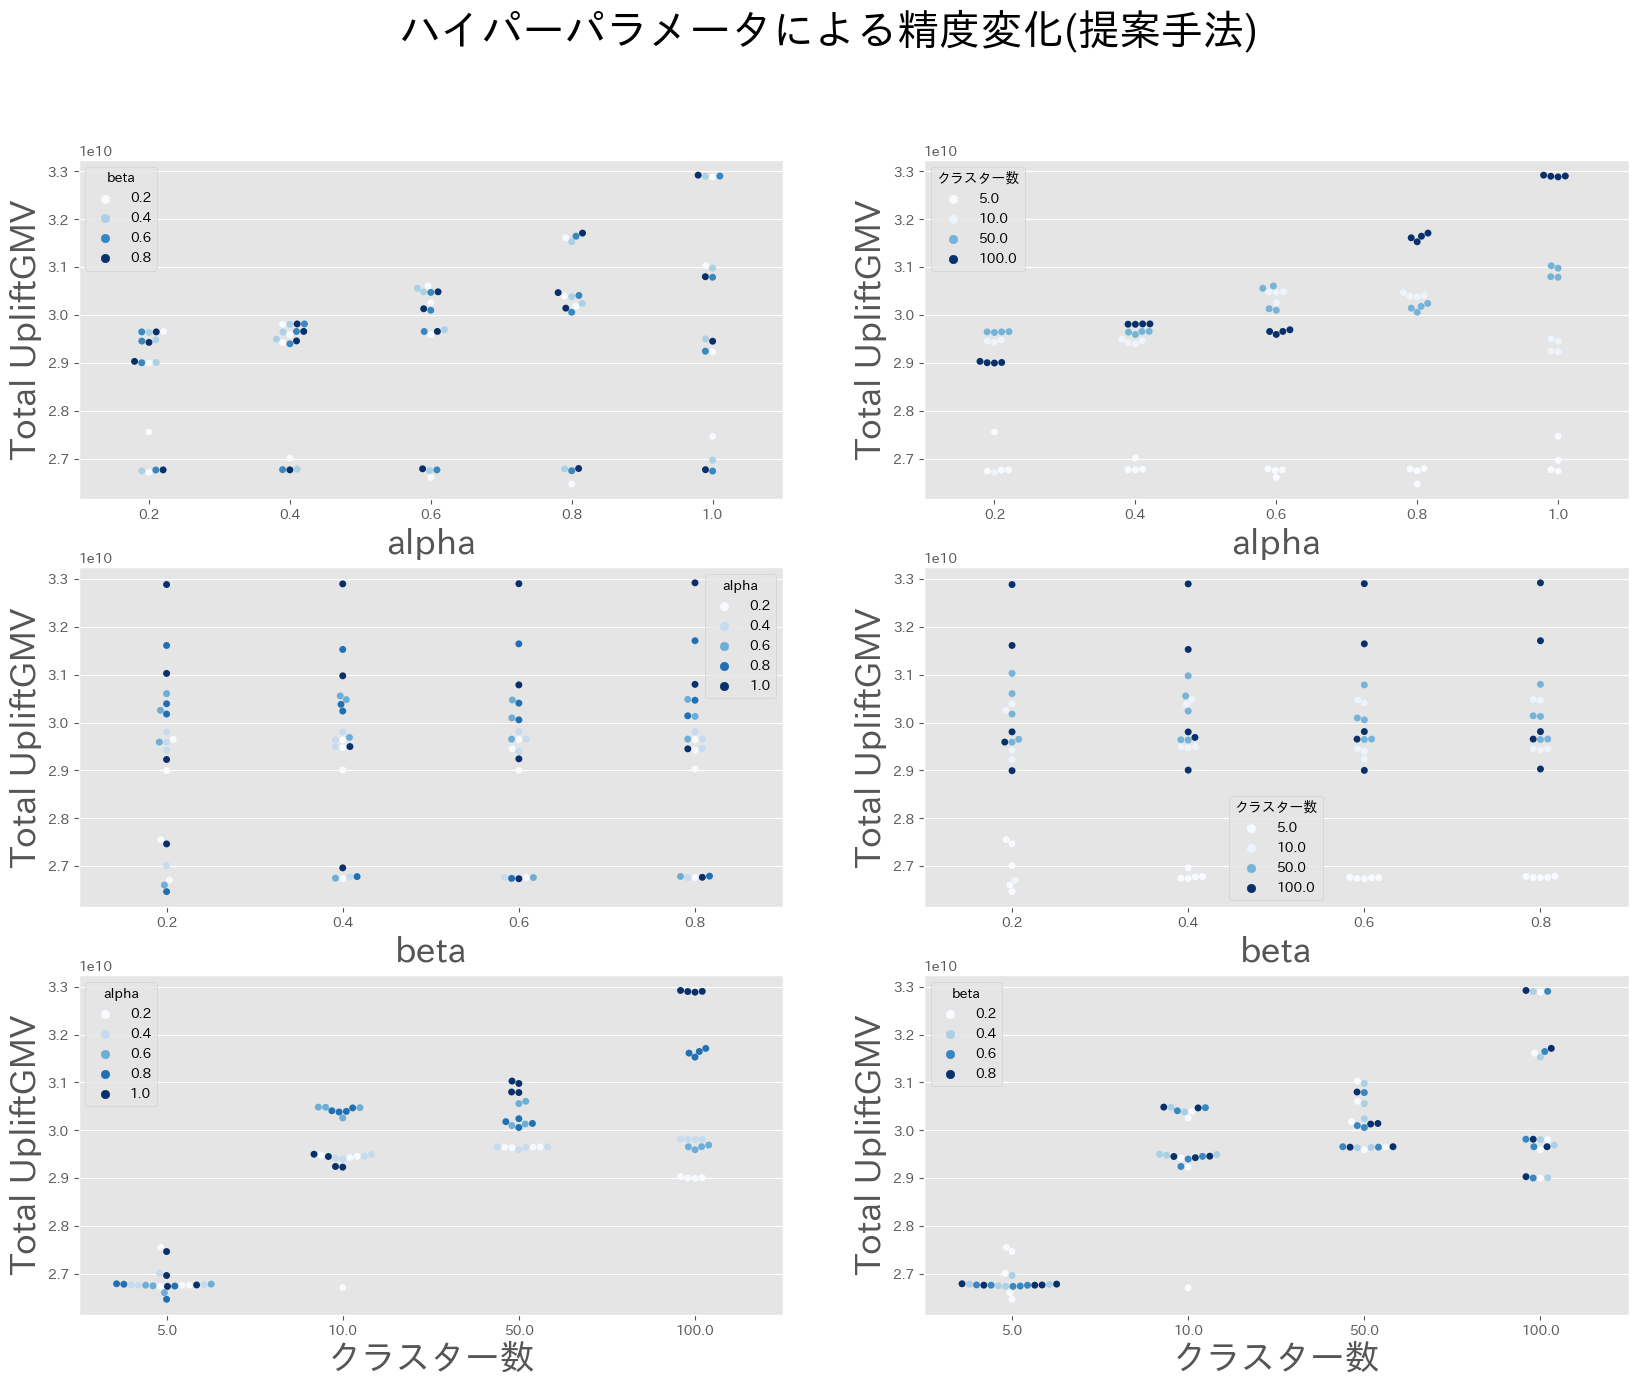

In [155]:
params =  ['alpha', 'beta', 'クラスター数']
fig, axes = plt.subplots(3, 2, figsize=(10*2, 5*3))
axes = axes.flatten()
i = 0
for x in params:
    for hue in [param for param in params if param != x]:
        ax = axes[i]
        sns.swarmplot(x=agg_df[x], y=agg_df['Total_GMV'], hue=agg_df[hue], palette='Blues', ax=ax)
        ax.set_xlabel(x, fontsize=25)
        ax.set_ylabel('Total UpliftGMV', fontsize=25)

        i += 1

# fig.tight_layout()
fig.suptitle('ハイパーパラメータによる精度変化(提案手法)', fontsize=30)